In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
#file = "../data/shapefiles/FAPAN_domain/SUBID_TotalDomain_WGS84_20140428_2_repaired_geometry.shp"    
file = "../data/shapefiles/FAPAN_domain_fixed_geometry/FAPAN_domain_fixed_geometry_availability.shp"    
# open file
shp = gpd.read_file(file)
df = pd.read_csv("../data/FAPAN204_inline.csv")

In [67]:
sum(df["SUBID"]!=shp["SUBID"])

0

In [68]:
#although geometries where fixed with qgis algorithm these polygons still have something invalid
shp = shp.drop([4342, 15720, 19878])

In [69]:
shp = shp[shp["PRC_AVAIL"]>0.5]
shp = shp.reset_index(drop=True)

In [70]:
df = df[df['SUBID'].isin(shp['SUBID'])]
df = df.reset_index(drop=True)
shp = shp.reset_index(drop=True)

Delete sub-basins which never have a value (81)

In [71]:
cols = list(map(str, range(1, 205)))
indexes_to_drop = df[df[cols].isnull().all(axis=1)].index

In [72]:
df = df.drop(indexes_to_drop)
shp = shp.drop(indexes_to_drop)
df = df.reset_index(drop=True)
shp = shp.reset_index(drop=True)

In [73]:
print(df.shape)
print(shp.shape)

(33694, 207)
(33694, 22)


In [74]:
shp['SUBID'] = shp['SUBID'].astype(int).astype(str)
shp.to_file('../data/shapefiles/FAPAN_domain_fixed_geometry/FAPAN_domain_fixed_geometry_availability05_final.shp')
df['SUBID'] = df['SUBID'].astype(int).astype(str)
df.to_csv('../data/FAPAN204_05.csv', index=False)

(45.0, 46.5)

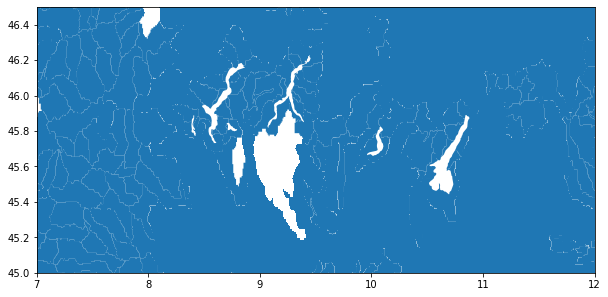

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))

shp.plot(ax=ax)

ax.set_xlim(7, 12)
ax.set_ylim(45, 46.5)

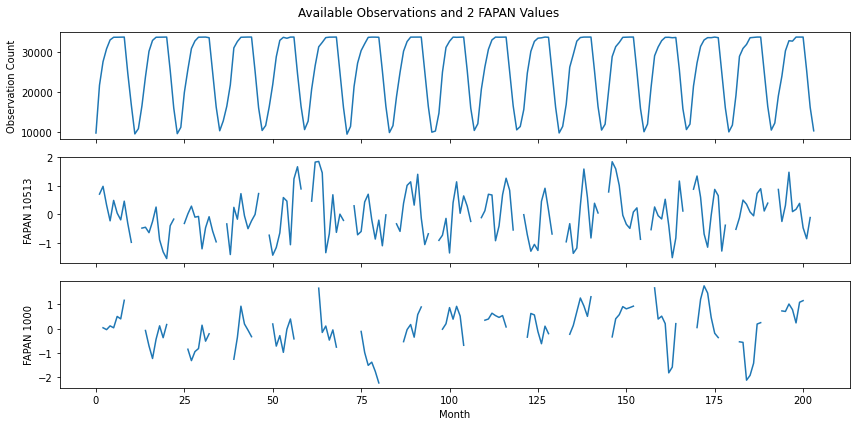

In [41]:
noNaN_count = df.iloc[:,3:].notna().sum(axis=0)
x = np.arange(len(noNaN_count))

fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)
fig.suptitle('Available Observations and 2 FAPAN Values')

axs[0].plot(x, noNaN_count.values)
axs[0].set_ylabel('Observation Count')

axs[1].plot(x, df.iloc[10513, 3:].values)
axs[1].set_ylabel('FAPAN 10513')

axs[2].plot(x, df.iloc[1000, 3:].values)
axs[2].set_ylabel('FAPAN 1000')
axs[2].set_xlabel('Month')

# Hide x labels for the top and middle plots
for ax in axs[:2]:
    ax.label_outer()

plt.tight_layout()
plt.show()

In [ ]:
def select_columns_by_months(dataframe, selected_months):
    selected_columns = []

    for i in range((dataframe.shape[1] - 3) // 12):
        selected_columns.extend([month + i * 12 for month in selected_months])

    all_columns = np.arange(1, dataframe.shape[1] - 2)
    columns_to_drop = np.setdiff1d(all_columns, np.array(selected_columns))
    columns_to_drop = [str(i) for i in columns_to_drop]

    filtered_dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

    return filtered_dataframe

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_51687/2575648416.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
100%|██████████| 12/12 [16:15<00:00, 81.30s/it]

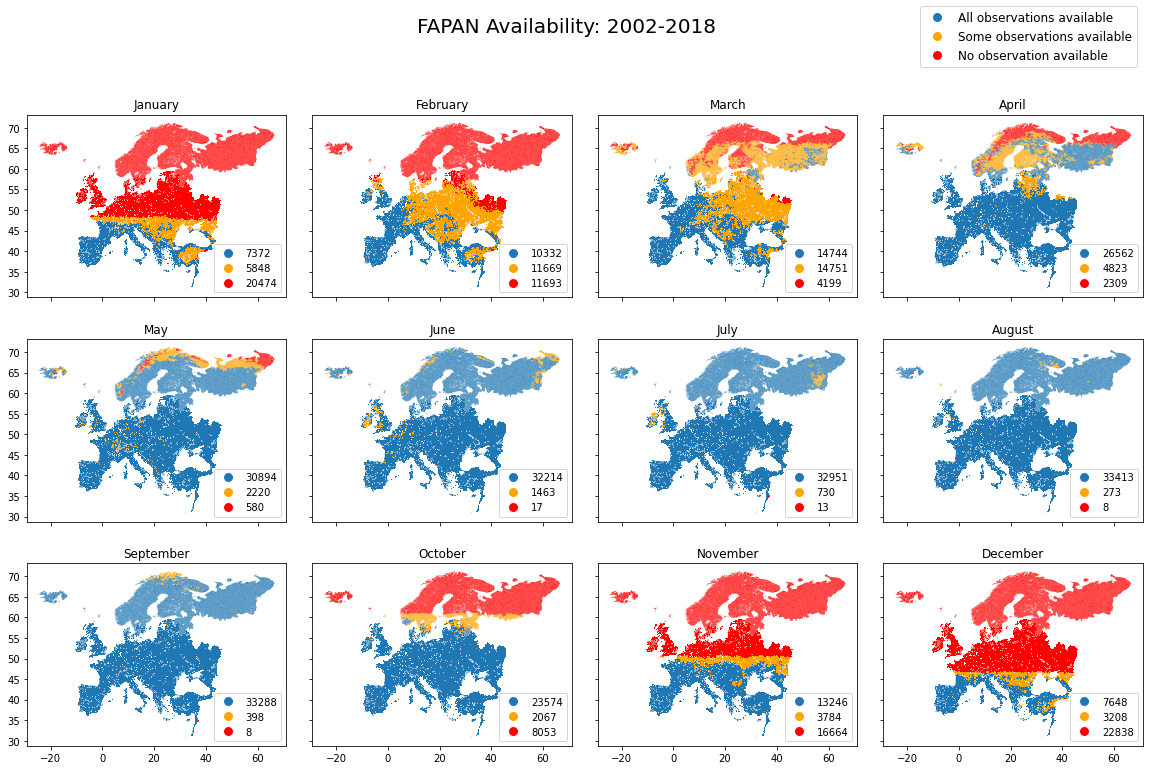

In [43]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True, constrained_layout=True)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

fig.suptitle('FAPAN Availability: 2002-2018', fontsize=20)
colors = {'df_month_no_na': 'C0', 'df_month_some_na': 'orange', 'df_month_all_na': 'red'}

progress_bar = tqdm(total=12, position=0, leave=True, smoothing=0)

k = 1
for i in range(3):
    for j in range(4):
        df_month = select_columns_by_months(df, [k])
        selected_columns = df_month.iloc[:, 3:]

        df_month_no_na = df_month.dropna()
        df_month_some_na = df_month[selected_columns.isnull().any(axis=1) & ~selected_columns.isnull().all(axis=1)]
        df_month_all_na = df_month[selected_columns.isnull().all(axis=1)]

        shp.plot(ax=axs[i][j], color=[colors.get('df_month_no_na') if subid in df_month_no_na['SUBID'].values
                                       else colors.get('df_month_some_na') if subid in df_month_some_na['SUBID'].values
                                       else colors.get('df_month_all_na') for subid in shp['SUBID']])

        month_name = calendar.month_name[k]
        axs[i][j].set_title(f'{month_name}', fontsize=12)

        # Count the occurrences of each color
        color_counts = [str(len(df_month_no_na)), str(len(df_month_some_na)), str(len(df_month_all_na))]

        axs[i][j].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
                                  for color in colors.values()],
                         labels=color_counts,
                         loc='lower right', fontsize=10)

        k += 1
        progress_bar.update(1)

# Create a legend outside the loop for the last plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
labels = ['All observations available', 'Some observations available', 'No observation available']
fig.legend(handles=handles, labels=labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.9, 1))


#plt.savefig(fname='availability_each_month.png')

plt.show()

/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_51687/1107848526.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.05, hspace=0.1)
100%|██████████| 6/6 [06:54<00:00, 69.05s/it]

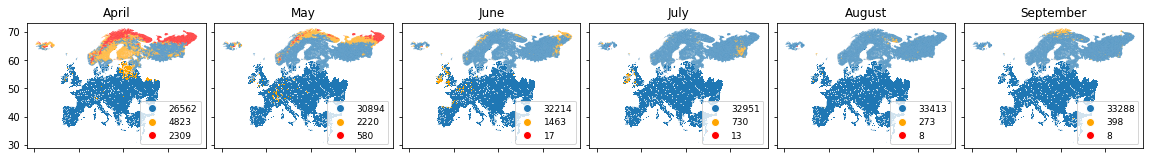

In [44]:
fig, axs = plt.subplots(1, 6, figsize=(20, 5), sharex=True, sharey=True, constrained_layout=True)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.1)

#fig.suptitle('FAPAN Availability level 7: 2002-2018', fontsize=20)
colors = {'df_month_no_na': 'C0', 'df_month_some_na': 'orange', 'df_month_all_na': 'red'}

progress_bar = tqdm(total=6, position=0, leave=True, smoothing=0)

k = 4
for i in range(1):
    for j in range(6):
        df_month = select_columns_by_months(df, [k])
        selected_columns = df_month.iloc[:, 3:]

        df_month_no_na = df_month.dropna()
        df_month_some_na = df_month[selected_columns.isnull().any(axis=1) & ~selected_columns.isnull().all(axis=1)]
        df_month_all_na = df_month[selected_columns.isnull().all(axis=1)]

        shp.plot(ax=axs[j], color=[colors.get('df_month_no_na') if subid in df_month_no_na['SUBID'].values
                                       else colors.get('df_month_some_na') if subid in df_month_some_na['SUBID'].values
                                       else colors.get('df_month_all_na') for subid in shp['SUBID']])

        month_name = calendar.month_name[k]
        axs[j].set_title(f'{month_name}', fontsize=12)

        # Count the occurrences of each color
        color_counts = [str(len(df_month_no_na)), str(len(df_month_some_na)), str(len(df_month_all_na))]

        axs[j].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) 
                                  for color in colors.values()],
                         labels=color_counts,
                         loc='lower right', fontsize=9)

        axs[j].set_xticklabels([])  # Remove x-tick labels

        k += 1
        progress_bar.update(1)

# Create a legend outside the loop for the last plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
labels = ['All observations available', 'Some observations available', 'No observations available']
#fig.legend(handles=handles, labels=labels, loc='upper right', fontsize=12, bbox_to_anchor=(0.9, 1))


#plt.savefig(fname='availability_each_month.png')

plt.show()

In [88]:
def plot_availability(months, nan_threshold):
    df_month = select_columns_by_months(df, months)
    selected_columns = df_month.iloc[:, 3:]

    #df_month_no_na = df_month.dropna()
    df_month_a_or_less_na = df_month[selected_columns.isnull().sum(axis=1)<=nan_threshold]
    df_month_b_or_more_na = df_month[(selected_columns.isnull().sum(axis=1)>nan_threshold) & (~selected_columns.isnull().all(axis=1))]
    df_month_all_na = df_month[selected_columns.isnull().all(axis=1)]

    colors = {'df_month_a_or_less_na': 'C0', 'df_month_b_or_more_na': 'orange', 'df_month_all_na': 'red'}

    shp.plot(figsize=(16,16), color=[colors.get('df_month_a_or_less_na') if subid in df_month_a_or_less_na['SUBID'].values
                                    else colors.get('df_month_b_or_more_na') if subid in df_month_b_or_more_na['SUBID'].values
                                    else colors.get('df_month_all_na') for subid in shp['SUBID']])

    color_counts = [str(len(df_month_a_or_less_na)), str(len(df_month_b_or_more_na)), str(len(df_month_all_na))]

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
    labels = [f'{nan_threshold} or less observations missing ({color_counts[0]})', f'{nan_threshold+1} or more observations missing ({color_counts[1]})', f'No observation available ({color_counts[2]})']
    plt.legend(handles, labels, loc='lower right', fontsize='large')

    title = calendar.month_name[months[0]] if len(months) == 1 else calendar.month_name[months[0]]+'-'+calendar.month_name[months[-1]]
    if nan_threshold>0:
        title=title + f", keeping sub-basins with at most {nan_threshold} nan"
    plt.title(title, fontsize = 16)

    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)

    plt.show()

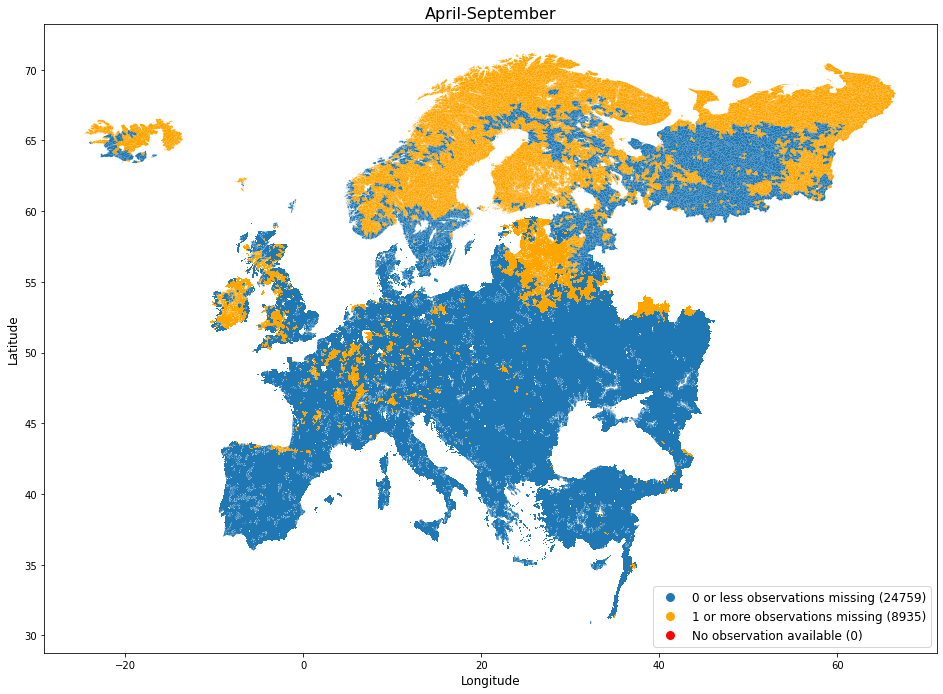

In [89]:
months = [4,5,6,7,8,9]
plot_availability(months, nan_threshold=0)

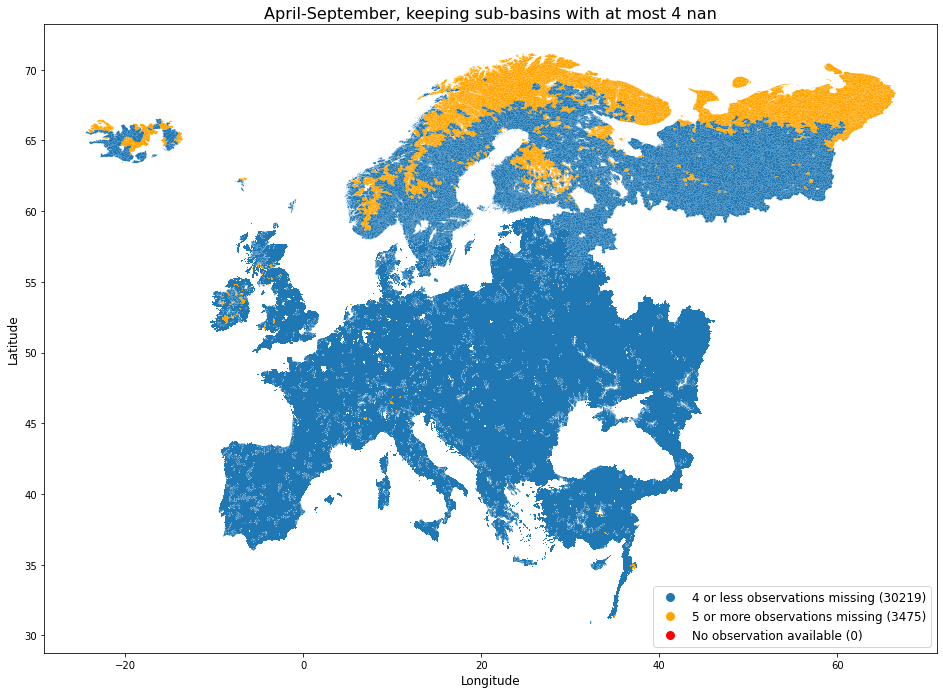

In [90]:
plot_availability(months, nan_threshold=4)

Text(0.5, 1.0, 'Original')

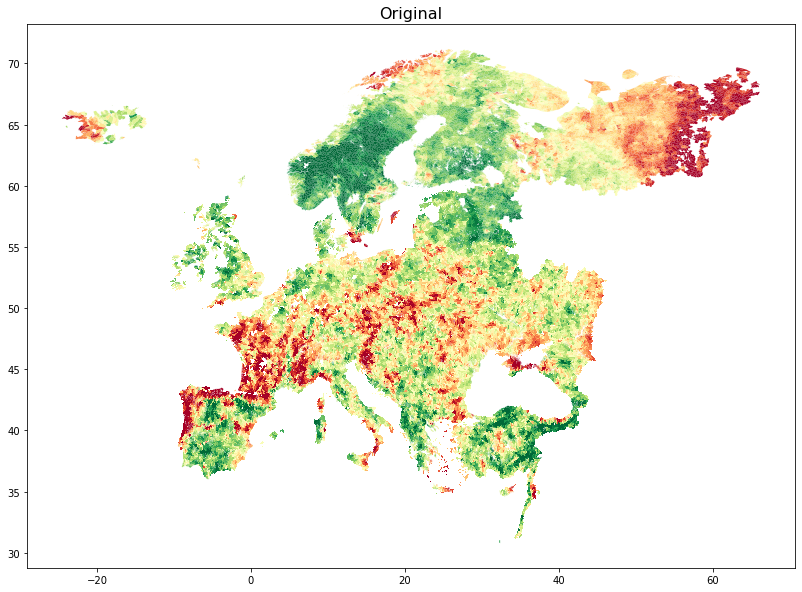

In [55]:
fig, ax = plt.subplots(figsize=(16, 10))

shp.plot(ax=ax, column=df['198'], cmap='RdYlGn', vmin=-2, vmax=2)
#ax.set_xlim(6, 14)
#ax.set_ylim(44, 48)

plt.title("Original", fontsize = 16)

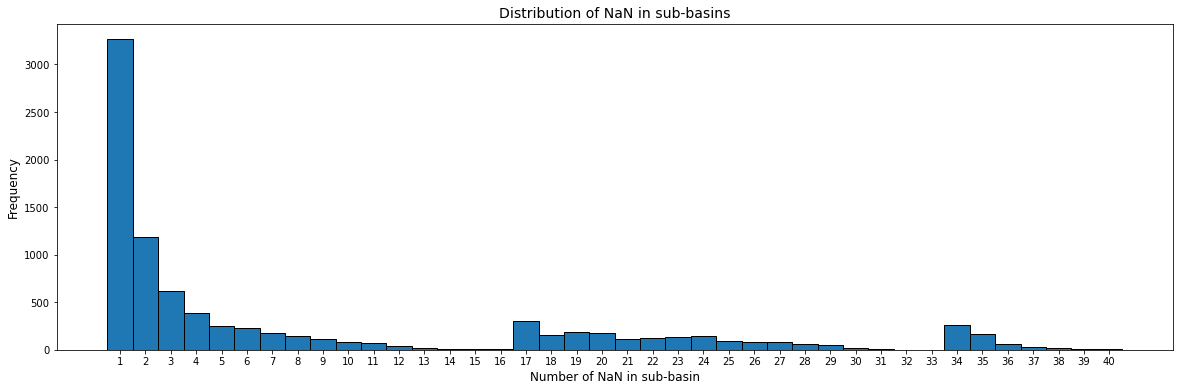

In [50]:
df_month = select_columns_by_months(df, [4,5,6,7,8,9])
selected_columns = df_month.iloc[:, 3:]
df_month_some_na = df_month[selected_columns.isnull().any(axis=1) & ~selected_columns.isnull().all(axis=1)]

nan_counts = df_month_some_na.isnull().sum(axis=1)

# Determine the number of bins and their limits

max_nan_counts = 40
min_nan_counts = min(nan_counts)
num_bins = max_nan_counts - min_nan_counts + 1

bins = np.arange(min_nan_counts - 0.5, max_nan_counts + 1.5, 1)

# Plot the distribution of NaN counts with centered integer ticks
plt.figure(figsize=(20, 6))
plt.hist(nan_counts, bins=bins, edgecolor='k')
plt.xticks(range(min_nan_counts, max_nan_counts + 1))
plt.xlabel('Number of NaN in sub-basin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of NaN in sub-basins', fontsize=14)
plt.show()

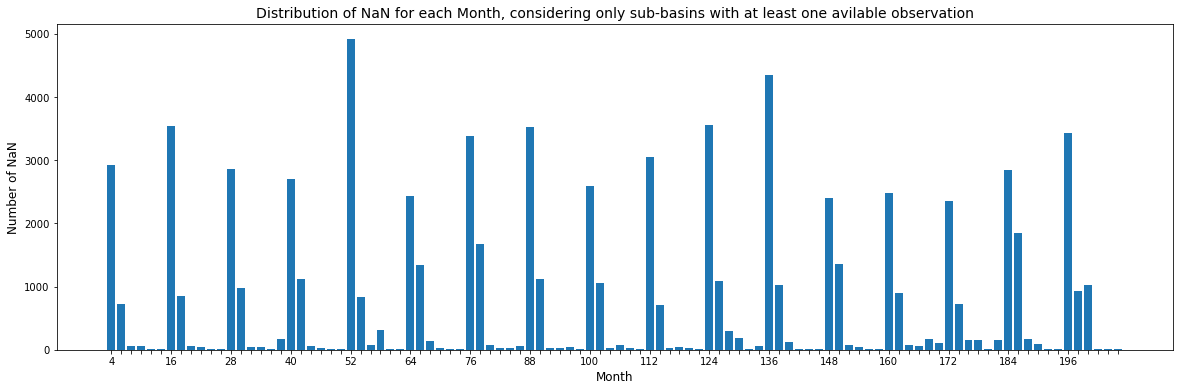

In [51]:
# Calculate the number of NaN values in each column
nan_counts = df_month_some_na.iloc[:, 3:].isnull().sum()

# Plot the distribution of NaN counts in columns
plt.figure(figsize=(20, 6))
plt.bar(nan_counts.index, nan_counts.values, align='center')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of NaN', fontsize=12)
plt.title('Distribution of NaN for each Month, considering only sub-basins with at least one avilable observation', fontsize=14)
months = [4,5,6,7,8,9]
months_ticks = []
for k in range(0, 12*17, 12):
    months_ticks.extend(np.array(months)+k)
all_ticks = months
relevant_ticks = [str(tick) if tick in [4+k for k in range(0, 12*17, 12)] else "" for tick in months_ticks]
plt.xticks(np.arange(0, len(nan_counts)), relevant_ticks)
plt.show()